In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

import datetime
from sklearn.preprocessing import MultiLabelBinarizer


df = pd.read_csv('./data/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


In [2]:
df.shape

(27643, 3)

In [15]:
df['Page content'].empty

False

In [52]:

def soup(text):
    # remove HTML tags
    return BeautifulSoup(text, 'html.parser')

def select_tag(text, tag):
    # remove HTML tags
    return BeautifulSoup(text, 'html.parser').select(tag)[0].text.strip()

def preprocessor(text):
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [51]:
# test for feature

soup = BeautifulSoup(df['Page content'][2], 'html.parser')

print(soup.select('.author_name a'))
print(soup.select('.author_name a')[0].text, '\n')

for elem in soup.select('.article-topics a'):
    print(elem.text)
    
print(len(soup.select('img')), '\n')
print(len(soup.select('iframe')), '\n')
print(BeautifulSoup(df['Page content'][2], 'html.parser').prettify())

[<a href="/author/sam-laird/">Sam Laird</a>]
Sam Laird 

Entertainment
NFL
NFL Draft
Sports
Television
2 

25 

<html>
 <head>
  <div class="article-info">
   <span class="byline">
    <a href="/author/sam-laird/">
     <img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/>
    </a>
    <span class="author_name">
     By
     <a href="/author/sam-laird/">
      Sam Laird
     </a>
    </span>
    <time datetime="Wed, 07 May 2014 19:15:20 +0000">
     2014-05-07 19:15:20 UTC
    </time>
   </span>
  </div>
 </head>
 <body>
  <h1 class="title">
   Ballin': 2014 NFL Draft Picks Get to Choose Their Own Walk-Out Music
  </h1>
  <figure class="article-image">
   <img alt="This Dec. 8, 2012 file photo shows Texas A&amp;M quarterback Johnny Manziel gesturing as he talks to reporters after 

In [60]:
def checkAuthor(soup):
    if len(soup.select('.author_name a')) == 0:
        return ''
    else:
        return soup.select('.author_name a')[0].text

df['result'] = df['Page content'].map(lambda x: soup(x))
df['author'] = df['result'].map(lambda x: checkAuthor(x))
df['time'] = df['result'].map(lambda x: x.select('time')[0].text)
df['time'] = df['time'].map(lambda x : datetime.datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S'))

df['topic'] = df['result'].map(lambda x: x.select('.article-topics a'))
df['image num'] = df['result'].map(lambda x: len(x.select('img')))
df['video num'] = df['result'].map(lambda x: len(x.select('iframe')))
df['body'] = df['result'].map(lambda x: x.select('body')[0].text.strip())

In [69]:
def flatten(arr_2D):
    result = []
    for arr in arr_2D:
        if len(arr) == 0:
            result.append(np.nan)
        else:
            result.append(arr.text)
    return result

df['topic'] = df['topic'].map(lambda x: flatten(x))

In [80]:
df['week of day'] = df['time'].map(lambda x: x.isoweekday() )
df['year'] = df['time'].map(lambda x: x.year )
df['month'] = df['time'].map(lambda x: x.month )
df['hour'] = df['time'].map(lambda x: x.hour )

In [83]:
df.drop(columns=['result']).to_csv('data/train_new_feature1.csv')

In [81]:
df.head(5)

,Id,Popularity,Page content,result,author,time,topic,image num,video num,body,week of day,year,month,hour
0,0,-1,"<html><head><div class=""article-info""> <span c...","[[[<div class=""article-info""> <span class=""byl...",,2013-06-19 15:04:30,"[Asteroid, Asteroids, challenge, Earth, Space,...",1,0,NASA's Grand Challenge: Stop Asteroids From De...,3,2013,6,15
1,1,1,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Christina Warren,2013-03-28 17:40:55,"[Apps and Software, Google, open source, opn p...",2,0,Google's New Open Source Patent Pledge: We Won...,4,2013,3,17
2,2,1,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Sam Laird,2014-05-07 19:15:20,"[Entertainment, NFL, NFL Draft, Sports, Televi...",2,25,Ballin': 2014 NFL Draft Picks Get to Choose Th...,3,2014,5,19
3,3,-1,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Sam Laird,2013-10-11 02:26:50,"[Sports, Video, Videos, Watercooler]",1,21,Cameraperson Fails Deliver Slapstick Laughs ...,5,2013,10,2
4,4,-1,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Connor Finnegan,2014-04-17 03:31:43,"[Entertainment, instagram, instagram video, NF...",52,1,NFL Star Helps Young Fan Prove Friendship With...,4,2014,4,3


In [86]:
df['weekend'] = df['week of day']
mask = df['weekend'] > 5 
df.loc[mask, 'weekend'] = 1
df.loc[~mask, 'weekend'] = 0

,Id,Popularity,Page content,result,author,time,topic,image num,video num,body,week of day,year,month,hour,weekend
0,0,-1,"<html><head><div class=""article-info""> <span c...","[[[<div class=""article-info""> <span class=""byl...",,2013-06-19 15:04:30,"[Asteroid, Asteroids, challenge, Earth, Space,...",1,0,NASA's Grand Challenge: Stop Asteroids From De...,3,2013,6,15,0
1,1,1,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Christina Warren,2013-03-28 17:40:55,"[Apps and Software, Google, open source, opn p...",2,0,Google's New Open Source Patent Pledge: We Won...,4,2013,3,17,0
2,2,1,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Sam Laird,2014-05-07 19:15:20,"[Entertainment, NFL, NFL Draft, Sports, Televi...",2,25,Ballin': 2014 NFL Draft Picks Get to Choose Th...,3,2014,5,19,0
3,3,-1,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Sam Laird,2013-10-11 02:26:50,"[Sports, Video, Videos, Watercooler]",1,21,Cameraperson Fails Deliver Slapstick Laughs ...,5,2013,10,2,0
4,4,-1,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Connor Finnegan,2014-04-17 03:31:43,"[Entertainment, instagram, instagram video, NF...",52,1,NFL Star Helps Young Fan Prove Friendship With...,4,2014,4,3,0


In [151]:
df['link num'] = df['result'].map(lambda x : len(x.select('a')))
df['body word count'] = df['body'].map(lambda x : len(x))

In [158]:
df['body word count'].describe()

count    2.764300e+04
mean     3.733846e+03
std      2.459043e+04
min      1.950000e+02
25%      1.601000e+03
50%      2.575000e+03
75%      4.405000e+03
max      2.104095e+06
Name: body word count, dtype: float64

In [278]:
df['log body word count'] = round(np.log(df['body word count']))
print(df['log body word count'].describe())

count    27643.000000
mean         7.885541
std          0.771570
min          5.000000
25%          7.000000
50%          8.000000
75%          8.000000
max         15.000000
Name: log body word count, dtype: float64


In [372]:
# popular count / total 
author_map = {}
for auth in df['author'].unique():
    mask = df['author'] == auth # author match
    mask1 = df['Popularity'] == 1 # popular count
    auth_index = df[mask].index
    df.loc[auth_index, 'author score'] =  len(df[mask&mask1]) / len(df[mask])
    author_map[auth] = len(df[mask&mask1]) / len(df[mask])
    
print(author_map)

{'': 0.4827586206896552, 'Christina Warren': 0.49874686716791977, 'Sam Laird': 0.4342629482071713, 'Connor Finnegan': 0.5747126436781609, 'Brian Anthony Hernandez': 0.4988399071925754, 'Sandra Gonzalez': 0.43416370106761565, 'Sara Afzal': 0.425, 'Jason Abbruzzese': 0.47478991596638653, 'Amanda Wills': 0.48095238095238096, 'Andrea Romano': 0.47789473684210526, 'Stan Schroeder': 0.501953125, 'Seth Fiegerman': 0.46803900325027087, 'Todd Wasserman': 0.5, 'Lorenzo Franceschi-Bicchierai': 0.4827586206896552, 'Christine Erickson': 0.5475285171102662, 'Christopher Miller': 0.49, 'Max Knoblauch': 0.48214285714285715, 'Emily Chow': 0.6666666666666666, 'Lance Ulanoff': 0.46851385390428213, 'Cheri Warren': 1.0, 'Megan Specia': 0.45794392523364486, 'Gabe Bergado': 0.4827586206896552, 'Alex Hazlett': 0.9, 'Brian Ries': 0.45985401459854014, 'Jenni Ryall': 0.452755905511811, 'Neha Prakash': 0.509469696969697, 'Kari Paul': 0.3978494623655914, 'Kurt Wagner': 0.49850746268656715, 'Rebecca Hiscott': 0.701

count    27643.000000
mean         0.493145
std          0.078167
min          0.000000
25%          0.470716
50%          0.482759
75%          0.501953
max          1.000000
Name: author score, dtype: float64


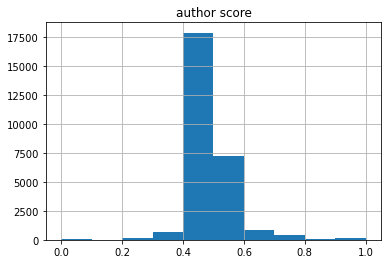

In [371]:
df.hist(column=['author score'])
print(df['author score'].describe())

In [442]:
def map_author(author):
    if author in author_map.keys():
        return author_map[author]
    # return mean
    return 0.493145 

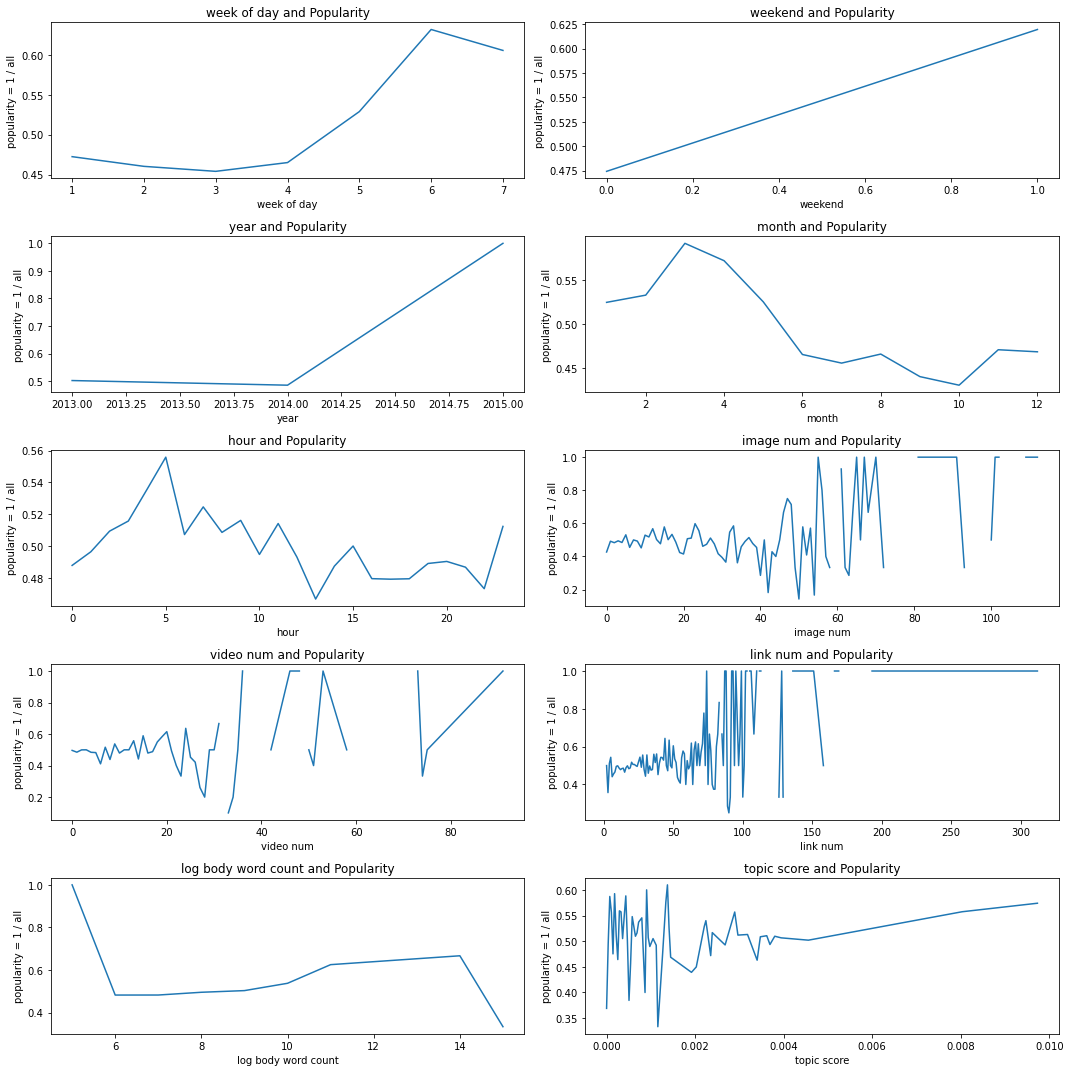

In [439]:
import matplotlib.pyplot as plt

def visualize_relation(column_name, x, y):
    mask = df['Popularity'] == 1
    posIndex = df[mask].index
    count = df.loc[posIndex, column_name].value_counts() / df.loc[:, column_name].value_counts()
    count = count.sort_index()
    
    if column_name == 'body word count':
        axs[x, y].plot(count.index, np.log(count.values))
        axs[x, y].set_xlim([0, 14])
    else:
        axs[x, y].plot(count.index, count.values)
    axs[x, y].set_xlabel(column_name)
    axs[x, y].set_ylabel('popularity = 1 / all')
    axs[x, y].set_title(column_name + " and Popularity")

    #print(df.loc[posIndex, column_name].value_counts() / df.loc[:, column_name].value_counts())
    
fig, axs = plt.subplots(5, 2, figsize=(15,15))

visualize_relation('week of day', 0, 0)
visualize_relation('weekend', 0, 1)
visualize_relation('year', 1, 0)
visualize_relation('month', 1, 1)
visualize_relation('hour', 2, 0)
visualize_relation('image num', 2, 1)
visualize_relation('video num', 3, 0)
visualize_relation('link num', 3, 1)
visualize_relation('log body word count', 4, 0)
visualize_relation('topic score', 4, 1)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


In [420]:
mask = df['Popularity'] == 1
posIndex = df[mask].index
count = df.loc[posIndex, 'author'].value_counts() / len(df)
print('num of popularity = 1\n', df.loc[posIndex, 'author'].value_counts())
print()
print('total:\n', df.loc[:, 'author'].value_counts())
print()
print(count)

print(count.sort_index())

num of popularity = 1
                      1288
Neha Prakash          538
Stan Schroeder        514
Todd Wasserman        457
Sam Laird             436
                     ... 
John Tabis              1
Chen Amit               1
Peter Pomerantsev       1
Carolyn Wickware        1
Amit De                 1
Name: author, Length: 347, dtype: int64

total:
                      2668
Neha Prakash         1056
Stan Schroeder       1024
Sam Laird            1004
Seth Fiegerman        923
                     ... 
Hot Wheels              1
Peter Pomerantsev       1
Laura Tillman           1
Shane Richmond          1
Amit De                 1
Name: author, Length: 428, dtype: int64

                     0.046594
Neha Prakash         0.019462
Stan Schroeder       0.018594
Todd Wasserman       0.016532
Sam Laird            0.015773
                       ...   
John Tabis           0.000036
Chen Amit            0.000036
Peter Pomerantsev    0.000036
Carolyn Wickware     0.000036
Amit De        

In [434]:
mlb = MultiLabelBinarizer()

oneHot_topic = pd.DataFrame(mlb.fit_transform(df['topic']),columns=mlb.classes_, index=df.index)

mask = df['Popularity'] == 1

popular_topic = pd.DataFrame(mlb.fit_transform(df.loc[mask, 'topic']),columns=mlb.classes_)
nonpopular_topic = pd.DataFrame(mlb.fit_transform(df.loc[~mask, 'topic']),columns=mlb.classes_)

# select the 100
# topic_100 = oneHot_topic.sum(axis = 0).sort_values(ascending=False)[:100].index
# popular_100 = popular_topic.sum(axis = 0).sort_values(ascending=False)[:100].index

# print("Not Popular but lots of:", set(topic_100) - set(popular_100))
perc = ( popular_topic.sum(axis = 0) - nonpopular_topic.sum(axis = 0) ) / len(df)

perc = perc.sort_values(ascending=False)

# fill nan
perc.fillna(0, inplace=True)
topic_score_map = dict(perc)
print(perc) # .describe()
print(perc[perc > 0.5].index)

#print(topic_score_map)
print(mlb.classes_)
print(len(mlb.classes_))

Social Media         0.009731
Lifestyle            0.008031
Apps and Software    0.004558
apps                 0.003943
Tech                 0.003798
                       ...   
zoe saldana          0.000000
zombie               0.000000
zombieland           0.000000
zoosk                0.000000
zulily               0.000000
Length: 14016, dtype: float64
Index([], dtype='object')
['"I Love It"' '#5facts' '#HeyUSA' ... 'zoo' 'zte' 'zulily']
9647


In [438]:
def map_topic_score(topic_list):
    sumScore = 0
    for topic in topic_list:
        if topic in topic_score_map.keys():
            sumScore = max(sumScore, topic_score_map[topic])
            #sumScore += topic_score_map[topic]
    return sumScore

df['topic score'] = df['topic'].map(lambda x: map_topic_score(x))
print(df['topic score'])

0        0.000398
1        0.004558
2        0.000253
3        0.000145
4        0.001121
           ...   
27638    0.000217
27639    0.004558
27640    0.003473
27641    0.000145
27642    0.000977
Name: topic score, Length: 27643, dtype: float64


In [431]:
df['topic'][1]

['Apps and Software',
 'Google',
 'open source',
 'opn pledge',
 'patent lawsuit theater',
 'software patents',
 'Tech',
 'U.S.']

In [108]:
for class_ in mlb.classes_:
    print(class_)

"I Love It"
#1Connection
#5facts
#6SecondPitch
#HeyUSA
#OccupyCentral
#aiww
#askacop
#bring
#bringbackourgirls
#endmalaria
#flurofridays
#iPhone6questions
#instagramisdown
#internationalwomensday
#makefurhistory
#occupygoogle
#onewaveisallittakes
#sxsbondi
#takedownjulienblanc
#thankstony
#throwbacktunesday
#umbrellarevolution
#waterstonestexan
#worldwaterday
$100 bill
$99 music video
'60s Tech
'dark knight' shooting
1 World Trade Center
10
100 dollar bill
100th birthday
1080p
10th anniversary
12 Years a Slave
12 days
12 megapixel
140 proof
143Band
19 entertainment
1979 Islamic Revolution
1980s
1984
1989
1995
1password
20/20 Experience
2000s
2004
2008 campaign
2010 Celebrity Style Hall of Shame
2010 video music awards
2013
2013 VMAs
2013 webby awards
2014
2014 CES
2014 Corvette
2014 Corvette Stingray
2014 Oscars
2014 VMAs
2014 academy awards
2014 billboard awards
2014 election
2014 midterms
2014 world cup
2015
2016
2020
2048
20px
20th century fox
21st century fox
22 Jump Street
23andMe

New balance
NewFronts
NewTek
Newark
Newfoundland
News of the world
Newsweek
Newsy
Next Keyboard
NextDoor
Nextbit
Nexus
Nexus 10
Nexus 5
Nexus 7
Nexus 8
Nexus 9
Nexus Ad
Nexus Player
Nic Pizzolatto
Nick Bilton
Nick Cannon
Nick Kristof
Nick Pitera
Nicki Minaj
Nicole Kidman
Nielsen Media Research
Nielsen SoundScan
Nietzsche
Nigerian girls
Nightcrawler
Nike
Nike Fuelband SE Review
Nike+ FuelBand
Nike+ Kinect
Nikola Tesla
Nikon
Nile Rogers
NimbleTV
Nine Inch Nails
Ninja Sphere
Nintendo
Nintendo Wii U
Nissan
Nissan ZEOD RC
No Shave November
No-Hitter
Nobel
Noir
Nokia
Nokia 105
Nokia Lumia 1020
Nokia Lumia 1520
Nokia Lumia 520
Nokia Lumia 625
Nokia Lumia 720
Nokia Lumia 830
Nokia Lumia 900
Nokia Lumia 920
Nokia Music
Nokia N1
Nokia Siemens
Nokia X
Nokia XL
Nominations
Nominees
Nomophobia
Noob the Loser
Nook HD
Norfolk
North America Parks
North Carolina
North Dakota
North Korea
North West
Norway
Nose
Note 3
Notes app
Notre Dame
Nova Scotia
November 31
NowThis News
Nsync
Nuclear
Nuclear Plant
N

caracas
carbon
carbon bubble
carbon budget
carbon dioxide
carbon emissions
carbon footprint
carbon reduction
carbon tax
carbyne
cardboard
cardcontrol
cards against humanity
career advice
career expert
career guidance
career hunting
career move
careerbuilder
carl icahn
carly fiorina
carly simon
carnival
caroling
carpathian villages
carpool
carribean
carrie
carrier pigeon
carriers
cars 2
carsharing
carter
cartoon
cartoon hangover
cartoon network
cartoons
carving
case
case mods
cases
cash
cash prizes
casinos
cassette
castAR
castaway
casting call
castle in the sky
castro
casual games
cat cafe
cat videos
catapult
catchphrase
categories
categorizing
catfish
catholic church
cathy freeman
cathy freeman's body suit
cats
cats of instagram
catvengers
catwoman
caught
causes
cbs news
cbs sports
cbs studios
cctv
cdn
cease & desist
ceelo
celbrities
celebrations
celebrity hack
celebrity news
celebrity photo hack
celebrity pictures
celebrity products
celebrtities
celebs
cell
cell phone etiquette
cell p

jenga
jennifer aniston
jennifer garner
jennifer lawrence
jennifer price
jennifer-lopez
jenny mccarthy
jeremy gutsche
jeremy meeks
jerry brown
jerry seinfeld
jerry yang
jersey
jesse pinkman
jesus
jet
jet engine
jet lag
jetblue
jetpac
jetpack
jets
jetsetter
jetstar
jewish
jian ghomeshi
jibo
jiff the wonder dog
jigsaw
jihad
jihadi
jill abramson
jim ambras
jimmy chin
jimmy fallon
jimmy iovine
jimmy kimmel
jingle bells
jj abrams
jk rowling
jlaw
joan rivers
job application
job applications
job board
job boards
job cuts
job hunt
job hunting
job interview
job interviews
job listings
job openings
job perks
job recruiting
job reviews
job search
job search apps
job seekers
job stress
job titles
jobless rate
jobs act
jobs board
jobs listing
joe diaz
joe fernandez
joe scarborough
joel mchale
john boehner
john carmack
john cena
john chen
john kerry
john key
john lennon
john malkovich
john mayer
john mulaney
john ridding
john zimmer
john-legend
johnnie walker
johnny depp
johnny manziel
jokes
jon bon 

simulation
sina weibo
sinaloa cartel
singapore airlines
singer
singing
single
singles
singles day
singtel
singularity
sinkhole
siri
siri assistant
sirius xm
siriusXM
sisters
sitcom
sitcoms
site design
six degrees of separation
six point harness
six strikes
six word stories
sixense
skateboard
skateboarding kid
sketch comedy
sketch video
sketchfab
ski jump
ski resorts
ski season
skiing
skills
skillshare
skillz
skimmer
skin
skin cancer
skrillex
skrim
sky
skydive
skylanders
skype translator
skyrim
slang
slash
slayer
sled dog race
sleep
sleep hollow
sleep tracking
sleeping
sleeping beauty
slenderman
slideshare
sling
sling media
slingbox
slip n slide
slo-mo
slopestyle
sloppy joe
sloth
sloths
sloviansk
slow
slow down
slow loris
slow motion videos
slow tv
slow-mo
slurpee
slut-shaming
sly and the family stone
small business loan
small business solutions
small business tips
small businesses
smalley
smallpox
smarphones
smarpthone
smart appliance
smart cars
smart cities
smart garden
smart glasses


In [168]:
# seperate the feature, categorical => need to do something

df_numerical = df[['image num', 'video num', 'link num', 'year', 'month', 'hour', 'weekend']]
df_categorical = df[['author', 'body', 'topic']]

In [174]:
df[['author', 'body', 'topic']].index

RangeIndex(start=0, stop=27643, step=1)

In [447]:
import pickle

with open('data/endofyear.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    toEndOfYear, toEndOfYear_test = pickle.load(f)
print(len(toEndOfYear), len(toEndOfYear_test))

df['toEndOfYear'] = toEndOfYear

27643 11847


In [95]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

print(tokenizer_stem_nostop('runners like running and thus they run'))

['runner', 'like', 'run', 'thu', 'run']


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Tf-idf

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,1),
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(body)

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    print('%s: %.2f' %(tfidf.get_feature_names()[sorted_idx[i]], idf[sorted_idx[i]]))

body_tfidf = tfidf.transform(body).toarray()


[vocabularies with smallest idf scores]
topic: 1.00
also: 1.11
see: 1.15
imag: 1.22
one: 1.50
new: 1.56
like: 1.60
time: 1.61
make: 1.72
year: 1.73


NameError: name 'np' is not defined

In [29]:
import numpy as np

tfidf_sum = np.sum(body_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones(tfidf_sum.shape[0]))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))


[vocabularies with highest tf-idf scores]
imag: 878.3647021402153
video: 709.0215071813932
app: 574.2870268301094
new: 484.00853468723056
googl: 459.04669357502667
game: 426.6907938974182
also: 419.3489716327387
appl: 406.14862901555995
facebook: 405.6823850364736
one: 403.9003695407535


In [30]:
df_idf = pd.DataFrame()
df_idf['title'] = title
df_idf['timestamp'] = timestamp
df_idf['body'] = body

In [31]:
df_idf.head(5)

,title,timestamp,body
0,NASA's Grand Challenge: Stop Asteroids From De...,2013-06-19 15:04:30 UTC,NASA's Grand Challenge: Stop Asteroids From De...
1,Google's New Open Source Patent Pledge: We Won...,2013-03-28 17:40:55 UTC,Google's New Open Source Patent Pledge: We Won...
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,2014-05-07 19:15:20 UTC,Ballin': 2014 NFL Draft Picks Get to Choose Th...
3,Cameraperson Fails Deliver Slapstick Laughs,2013-10-11 02:26:50 UTC,Cameraperson Fails Deliver Slapstick Laughs ...
4,NFL Star Helps Young Fan Prove Friendship With...,2014-04-17 03:31:43 UTC,NFL Star Helps Young Fan Prove Friendship With...


In [192]:
df_idf['title word count'] = df_idf['title'].map(lambda x: len(x))
df_idf['body word count'] = df_idf['body'].map(lambda x: len(x))

In [193]:
df_idf.head(5)

,title,timestamp,body,title word count,body word count
0,NASA's Grand Challenge: Stop Asteroids From De...,2013-06-19 15:04:30 UTC,NASA's Grand Challenge: Stop Asteroids From De...,60,3717
1,Google's New Open Source Patent Pledge: We Won...,2013-03-28 17:40:55 UTC,Google's New Open Source Patent Pledge: We Won...,74,2030
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,2014-05-07 19:15:20 UTC,Ballin': 2014 NFL Draft Picks Get to Choose Th...,68,6964
3,Cameraperson Fails Deliver Slapstick Laughs,2013-10-11 02:26:50 UTC,Cameraperson Fails Deliver Slapstick Laughs ...,43,1907
4,NFL Star Helps Young Fan Prove Friendship With...,2014-04-17 03:31:43 UTC,NFL Star Helps Young Fan Prove Friendship With...,61,9240


In [207]:
df_idf['Popularity'] = df['Popularity']

print(df_idf.corr()['Popularity']['title word count'])
print(df_idf.corr()['Popularity']['body word count'])

-0.025900967324863546
0.00054793147098898


In [41]:
# body vector
body_tfidf.shape
# # save the parameter
# %store body_tfidf
# %store df_idf

# # load the parameter
# %store -r body_tfidf
# %store -r df_idf


0.0

If using the tf-idf, the dimension is too high.
So instead, use the feature hashing

# Feature Hashing

**Body -> word2vec** 

In [169]:
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

# hash words to 1024 buckets
hashvec = HashingVectorizer(n_features=2**10,
                            preprocessor=preprocessor,
                            tokenizer=tokenizer_stem_nostop)

# no .fit needed for HashingVectorizer, since it's defined by the hash function

# transform sentences to vectors of dimension 1024
body_hash = hashvec.transform(df_categorical['body'])

#body_hash = hashvec.transform(body)
#title_hash = hashvec.transform(title)
# print(body_hash.shape)
# print(title_hash.shape)

print(body_hash.shape)

(27643, 1024)


In [226]:
print(mixed)

  (0, 2676)	1.0
  (1, 792)	1.0


# One hot Encoding
**author** -> unique value: 428

Some author always wrote news that are popular.

In [171]:
len(df_categorical['author'].unique())

428

In [448]:
# body would be used in
df_train = df.drop(columns=['Id', 'Page content', 'result', 'time', 'topic', 'body word count', 'Popularity', 'week of day'])
df_train.head(5)

,author,image num,video num,body,year,month,hour,weekend,link num,log body word count,author score,topic score,toEndOfYear
0,,1,0,NASA's Grand Challenge: Stop Asteroids From De...,2013,6,15,0,22,8.0,0.482759,0.000398,195
1,Christina Warren,2,0,Google's New Open Source Patent Pledge: We Won...,2013,3,17,0,18,8.0,0.498747,0.004558,278
2,Sam Laird,2,25,Ballin': 2014 NFL Draft Picks Get to Choose Th...,2014,5,19,0,11,9.0,0.434263,0.000253,238
3,Sam Laird,1,21,Cameraperson Fails Deliver Slapstick Laughs ...,2013,10,2,0,13,8.0,0.434263,0.000145,81
4,Connor Finnegan,52,1,NFL Star Helps Young Fan Prove Friendship With...,2014,4,3,0,16,9.0,0.574713,0.001121,258


In [216]:
from sklearn.preprocessing import StandardScaler

std = ColumnTransformer([
        ('std', StandardScaler(), ['image num', 'video num', 'link num', 'month', 'hour'])
    ], remainder='passthrough')

df_train_std = std.fit_transform(df_train)

print(df_train_std)
print('before: ', df_train.shape)
print('after: ', df_train_std.shape)

[[-0.5830774676929511 -0.30559789106685487 0.26734296937044216 ... 3 2013
  0]
 [-0.4629524802551917 -0.30559789106685487 -0.07152703176706905 ... 4
  2013 0]
 [-0.4629524802551917 5.748150391024147 -0.6645495337577136 ... 3 2014 0]
 ...
 [1.098672356435681 -0.30559789106685487 0.35206046965481996 ... 4 2014 0]
 [-0.3428274928174323 -0.30559789106685487 -0.15624453205144684 ... 2
  2013 0]
 [-0.5830774676929511 -0.30559789106685487 0.35206046965481996 ... 5 2014
  0]]
before:  (27643, 10)
after:  (27643, 10)


In [217]:
# find the index of the categorical feature
catego_features = ['author', 'year']
hash_features = ['body']

catego_idx = []
hash_idx = []
for fea in catego_features:
    catego_idx.append(df_train.columns.tolist().index(fea))
    
for hash_ in hash_features:
    hash_idx.append(df_train.columns.tolist().index(hash_))

In [291]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


ohe = ColumnTransformer(
    [
        ("one_hot_encoder", OneHotEncoder(sparse = False, categories = "auto", handle_unknown = 'ignore'), catego_idx),
    ],
    remainder = "passthrough"
)


df_ohe = ohe.fit_transform(df_train)
print('Impute: {}'.format(df_train.shape))
print('Impute one-hot: {}'.format(df_ohe.shape))


Impute: (27643, 9)
Impute one-hot: (27643, 447)


In [219]:
df_ohe

array([[1.0, 0.0, 0.0, ..., 15, 0, 22],
       [0.0, 0.0, 0.0, ..., 17, 0, 18],
       [0.0, 0.0, 0.0, ..., 19, 0, 11],
       ...,
       [0.0, 0.0, 0.0, ..., 12, 0, 23],
       [0.0, 0.0, 0.0, ..., 20, 0, 17],
       [0.0, 0.0, 0.0, ..., 18, 0, 23]], dtype=object)

# Pipeline + XGBoost

In [299]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor, XGBClassifier

numeric_features = ['image num', 'video num', 'link num', 'month', 'hour']
catego_features = ['author', 'year']
hash_features = ['body']

hashvec = HashingVectorizer(n_features=2**10, preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)

preprocessorAll = ColumnTransformer(
    transformers=[
        ('scl', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(sparse = False, categories = "auto", handle_unknown = 'ignore'), catego_features),
        ('hash', hashvec , 'body')
    ],
    remainder = "passthrough"
)

#tmp = preprocessorAll.fit_transform(df_train)

In [229]:
tmp.shape

(27643, 1461)

In [300]:
pipe_xgb = Pipeline([
    ("preprocessorAll", preprocessorAll),
    ("clf", XGBClassifier(eval_metric='auc'))
])

y = df['Popularity'].values
pipe_xgb.fit(df_train, y)

C:\Users\ginag\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ginag\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('preprocessorAll',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scl', StandardScaler(),
                                                  ['image num', 'video num',
                                                   'link num', 'month',
                                                   'hour']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['author', 'year']),
                                                 ('hash',
                                                  HashingVectorizer(n_features=1024,
                                                                    preprocessor=<function preprocessor at 0x0000025B3F0275E0>,
                                                    

In [296]:
y_pred = pipe_xgb.predict(df_train)
print('', pipe_xgb.predict_proba(df_train)[:, 1])

 [0.2099725  0.64290243 0.50603944 ... 0.31651306 0.3294874  0.45112044]


In [239]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred, y))

0.85985602141591


In [196]:
body_hash.toarray().shape

(27643, 1024)

## Relation between week day and Popularity

In [68]:

mask = df['Popularity'] == -1
neg_index = df[mask].index
pos_index = df[~mask].index

tmp = pd.DataFrame()
tmp['week_of_day'] = week_of_day[neg_index]
tmp['value'] = df[mask]['Popularity']

print('[Popularity = -1]')
print(tmp.groupby(by=['week_of_day']).count())

tmp = pd.DataFrame()
tmp['week_of_day'] = week_of_day[pos_index]
tmp['value'] = df[~mask]['Popularity']

print('\n[Popularity = 1]')
print(tmp.groupby(by=['week_of_day']).count())

[Popularity = -1]
             value
week_of_day       
0             2366
1             2720
2             2828
3             2740
4             1992
5              695
6              670

[Popularity = 1]
             value
week_of_day       
0             2119
1             2320
2             2352
3             2382
4             2237
5             1193
6             1029


In [228]:
# horizontal these features
df_hash = np.hstack([title_hash.toarray(), body_hash.toarray(), 
                     week_of_day.to_numpy().reshape(-1, 1)])

y = df['Popularity'].values

In [231]:
y.shape

(27643,)

# Traing with model - XGBoost

In [235]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(df_hash, y, test_size=0.3)

xgbmodel = XGBClassifier(eval_metric='auc')
xgbmodel.fit(X_train, y_train)

print(xgbmodel.classes_)
print(xgbmodel.predict_proba(df_small)[:, 1])

y_pred = xgbmodel.predict(X_train)
print(accuracy_score(y_pred, y_train))

y_val_pred = xgbmodel.predict(X_val)
print(accuracy_score(y_val_pred, y_val))

0.9003100775193799
0.5150126612805981


In [238]:
param_grid = [{ 'gamma': [0.1, 0.2, 0.3, 0.5, 0.7]} ] #'max_depth': [6, 8, 10]

y[ y == -1] = 0 # which means not popular -> to eliminate the warning of xgbmodel
gs = GridSearchCV(estimator=xgbmodel, 
                  param_grid=param_grid, 
                  scoring='accuracy')

gs.fit(df_hash, y)
print(gs.best_score_)
print(gs.best_params_)

C:\Users\ginag\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5323230701217813
{'gamma': 0.3}


## Going to test

In [490]:
test = pd.read_csv('data/test.csv')

In [491]:
def checkTime(text):
    if text == '':
        text = '2013-12-16 14:01:44'
    return datetime.datetime.strptime(text[:19], '%Y-%m-%d %H:%M:%S')

test['result'] = test['Page content'].map(lambda x: soup(x))
test['author'] = test['result'].map(lambda x: checkAuthor(x))
test['time'] = test['result'].map(lambda x: x.select('time')[0].text)
test['time'] = test['time'].map(lambda x : checkTime(x))

test['topic'] = test['result'].map(lambda x: x.select('.article-topics a'))
test['image num'] = test['result'].map(lambda x: len(x.select('img')))
test['video num'] = test['result'].map(lambda x: len(x.select('iframe')))
test['body'] = test['result'].map(lambda x: x.select('body')[0].text.strip())
test['topic'] = test['topic'].map(lambda x: flatten(x))

test['week of day'] = test['time'].map(lambda x: x.isoweekday() )
test['year'] = test['time'].map(lambda x: x.year )
test['month'] = test['time'].map(lambda x: x.month )
test['hour'] = test['time'].map(lambda x: x.hour )

In [492]:
test['body word count'] = test['body'].map(lambda x : len(x))

# transform to weekend
test['weekend'] = df['week of day']
mask = test['weekend'] > 5 
test.loc[mask, 'weekend'] = 1
test.loc[~mask, 'weekend'] = 0

test['link num'] = test['result'].map(lambda x : len(x.select('a')))
test['log body word count'] = round(np.log(df['body word count']))

test['author score'] = test['author'].map(lambda x: map_author(x))
test['topic score'] = test['topic'].map(lambda x: map_topic_score(x))
test['toEndOfYear'] = toEndOfYear_test

In [493]:
test.head(5)

,Id,Page content,result,author,time,topic,image num,video num,body,week of day,year,month,hour,body word count,weekend,link num,log body word count,author score,topic score,toEndOfYear
0,27643,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Sam Laird,2013-09-09 19:47:02,"[Entertainment, Music, One Direction, soccer, ...",1,7,Soccer Star Gets Twitter Death Threats After T...,1,2013,9,19,3506,0,30,8.0,0.434263,0.000000,113
1,27644,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Stan Schroeder,2013-10-31 09:25:02,"[Gadgets, glass, Google, Google Glass, Google ...",3,0,Google Glass Gets an Accessory Store Shortly a...,4,2013,10,9,922,0,13,8.0,0.501953,0.003798,61
2,27645,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Todd Wasserman,2013-06-25 12:54:54,"[amazon, amazon kindle, Business, Gaming]",2,0,OUYA Gaming Console Already Sold Out on Amazon...,2,2013,6,12,1084,0,13,9.0,0.500000,0.000072,189
3,27646,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Neha Prakash,2013-02-13 03:30:21,"[Between Two Ferns, Movies, The Oscars, Oscars...",1,4,'Between Two Ferns' Mocks Oscar Nominees Betw...,3,2013,2,3,1142,0,15,8.0,0.509470,0.000977,321
4,27647,"<html><head><div class=""article-info""><span cl...","[[[<div class=""article-info""><span class=""byli...",Josh Dickey,2014-10-03 01:34:54,"[American Sniper, Awards, Bradley Cooper, clin...",1,1,'American Sniper' Trailer: Looks Like Eastwood...,5,2014,10,1,1495,0,10,9.0,0.487013,0.000977,89


In [240]:
test['Popularity'] = xgbmodel.predict_proba(np_test)[:, 1]

In [241]:
test[['Id', 'Popularity']].to_csv('test_xgboost.csv', index=False)

In [252]:
test.loc[1585, 'week of day'] = 1

In [263]:
print(test[test.isna().any(axis=1)])

Empty DataFrame
Columns: [Id, Page content, result, author, time, topic, image num, video num, body, week of day, year, month, hour, body word count, weekend, link num]
Index: []


In [495]:
# Pipeline fit in test
# order must be author	image num	video num	body	year	month	hour	weekend	link num
id_fea = test['Id']
df_test = test.drop(columns=['Id', 'Page content', 'result', 'time', 'topic', 'body word count', 'week of day'])
df_test.head(5)

,author,image num,video num,body,year,month,hour,weekend,link num,log body word count,author score,topic score,toEndOfYear
0,Sam Laird,1,7,Soccer Star Gets Twitter Death Threats After T...,2013,9,19,0,30,8.0,0.434263,0.000000,113
1,Stan Schroeder,3,0,Google Glass Gets an Accessory Store Shortly a...,2013,10,9,0,13,8.0,0.501953,0.003798,61
2,Todd Wasserman,2,0,OUYA Gaming Console Already Sold Out on Amazon...,2013,6,12,0,13,9.0,0.500000,0.000072,189
3,Neha Prakash,1,4,'Between Two Ferns' Mocks Oscar Nominees Betw...,2013,2,3,0,15,8.0,0.509470,0.000977,321
4,Josh Dickey,1,1,'American Sniper' Trailer: Looks Like Eastwood...,2014,10,1,0,10,9.0,0.487013,0.000977,89


In [270]:
# df_test['author'].unique()
list(set(df_test['author']) - set(df_train['author']))

['Marrie Lobel',
 'Danielle Hernandez',
 'Patrick Hogan',
 'Aaron Pitman',
 "Bloomingdale's",
 'Ruby Karp',
 'Carmin Chappell',
 'Mashable and Channel 4 News',
 'Alexandre Douzet',
 'Love Bot',
 'Claudia Chan',
 'Tom Ewer',
 'Jayne Mattson',
 'Lisa A. Goldstein',
 'Chona Kasinger',
 'Kenneth Coats',
 'Bob Sullivan',
 'Adam Lewis',
 'John Skylar',
 'Michal Tsur',
 'Alisa Stern',
 'Adam Singolda',
 'John Harthorne',
 'Kenneth Rosen',
 'Col. Chris Hadfield',
 'Ron Conway',
 'Ian Ide',
 'Josh Mendelsohn',
 'Randi Zuckerberg',
 'Tongal',
 'Mona Bijoor',
 'Justin Miller',
 'Mont-Tremblant',
 'Nathan Parcells',
 'Michael Jones',
 'Yael Bar-tur',
 'Kristine Yapp',
 'Jessica Adamiak',
 'Tim Cannon',
 'Jay Haines',
 'Eugene Chung']

In [301]:
#y_pred = pipe_xgb.predict(df_test)
test['Popularity'] = pipe_xgb.predict_proba(df_test)[:, 1]

In [304]:
test[['Id', 'Popularity']].to_csv('test_xgboost_1.csv', index=False)

# Random Forest

In [326]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size=0.3)

# already try 5, 7, 10, best=10
max_depth = [10, 15, 20]

# already try 50, 100, 150, best=150
n_estimators = [150, 200, 250]

pipe_rf = Pipeline([
    ("preprocessorAll", preprocessorAll),
    ("clf", RandomForestClassifier())
])

# by adding two underlines (__) between step name and parameter name
param_grid = [{'clf__max_depth': max_depth, 
               'clf__n_estimators': n_estimators}]


gs = GridSearchCV(
    estimator = pipe_rf, 
    param_grid = param_grid, 
    scoring = "roc_auc",
    cv = 3
)

gs = gs.fit(X_train, y_train)
print('[Random Forest: grid search]')
print('Validation accuracy: %.3f' % gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(df_train, y)
#print('Test accuracy: %.3f' % clf.score(X_test, y_test))


C:\Users\ginag\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ginag\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ginag\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ginag\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ginag\anaconda3\lib\site-packages\s

[Random Forest: grid search]
Validation accuracy: 0.574
{'clf__max_depth': 10, 'clf__n_estimators': 250}


C:\Users\ginag\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Pipeline(steps=[('preprocessorAll',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scl', StandardScaler(),
                                                  ['image num', 'video num',
                                                   'link num', 'month',
                                                   'hour']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['author', 'year']),
                                                 ('hash',
                                                  HashingVectorizer(n_features=1024,
                                                                    preprocessor=<function preprocessor at 0x0000025B3F0275E0>,
                                                    

In [327]:
print('Test accuracy: %.3f' % clf.score(df_train, y))

Test accuracy: 0.770


In [328]:
#clf.fit(df_train, y)
test['Popularity'] = clf.predict_proba(df_test)[:, 1]

In [329]:
test[['Id', 'Popularity']].to_csv('data/test_random_forest_n_150.csv', index=False)

In [340]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

get_column_names_from_ColumnTransformer(preprocessorAll)

['image num',
 'video num',
 'link num',
 'month',
 'hour',
 'x0_',
 'x0_ Amy-Mae Turner',
 'x0_#MAKEFURHISTORY',
 'x0_AJ Marechal',
 'x0_Aaron Lee',
 'x0_Aaron Miguel Cantú',
 'x0_Adam Foroughi',
 'x0_Adam Ostrow',
 'x0_Adam Popescu',
 'x0_Adario Strange',
 'x0_Adelle Waldman',
 'x0_Admiral James Stavridis',
 'x0_Adobe Marketing Cloud',
 'x0_Adora Svitak',
 'x0_Afifa Siddiqui',
 'x0_Alan Carniol',
 'x0_Alan Danzis',
 'x0_Alex Fitzpatrick',
 'x0_Alex Hazlett',
 'x0_Alex Howard',
 'x0_Alex Magdaleno',
 'x0_Alex Thomson',
 'x0_Alex Torrenegra',
 'x0_Alexis Grant',
 'x0_Allison Kent-Smith',
 'x0_Allison Reiber',
 'x0_Amanda Dixon',
 'x0_Amanda Wills',
 'x0_Amit Chauhan',
 'x0_Amit De',
 'x0_Amy Burke',
 'x0_Amy Webb',
 'x0_Ana Rosenstein',
 'x0_Andre Lavoie',
 'x0_Andrea Romano',
 'x0_Andrea Smith',
 'x0_Andrew Freedman',
 'x0_Andrew Van Noy',
 'x0_Andy Fixmer',
 'x0_Anita Li',
 'x0_Ann-Marie Alcantara',
 'x0_Anna Parsons',
 'x0_Anna Washenko',
 'x0_Anne Park',
 'x0_Annie Colbert',
 'x0_A

1461


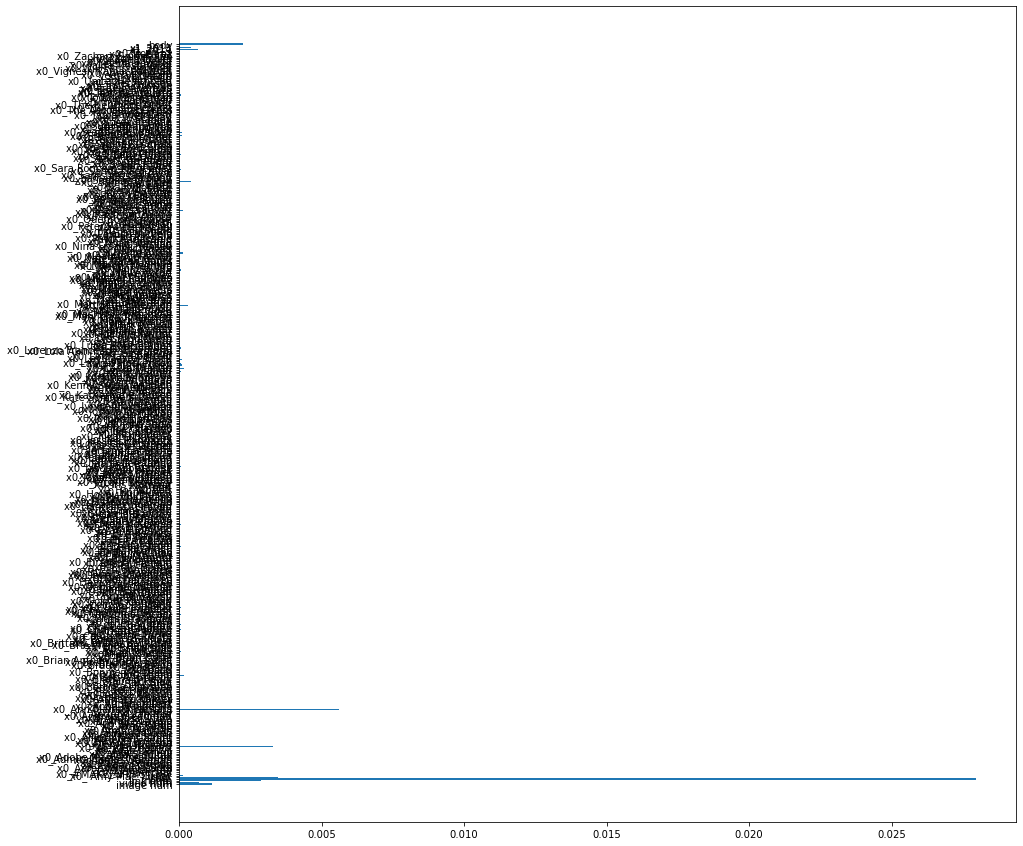

In [351]:
print(len(clf.steps[1][1].feature_importances_))
length = len(get_column_names_from_ColumnTransformer(preprocessorAll))
plt.figure(figsize=(15,15))

plt.barh(get_column_names_from_ColumnTransformer(preprocessorAll), clf.steps[1][1].feature_importances_[:length])
plt.show()

feature important > 0.001


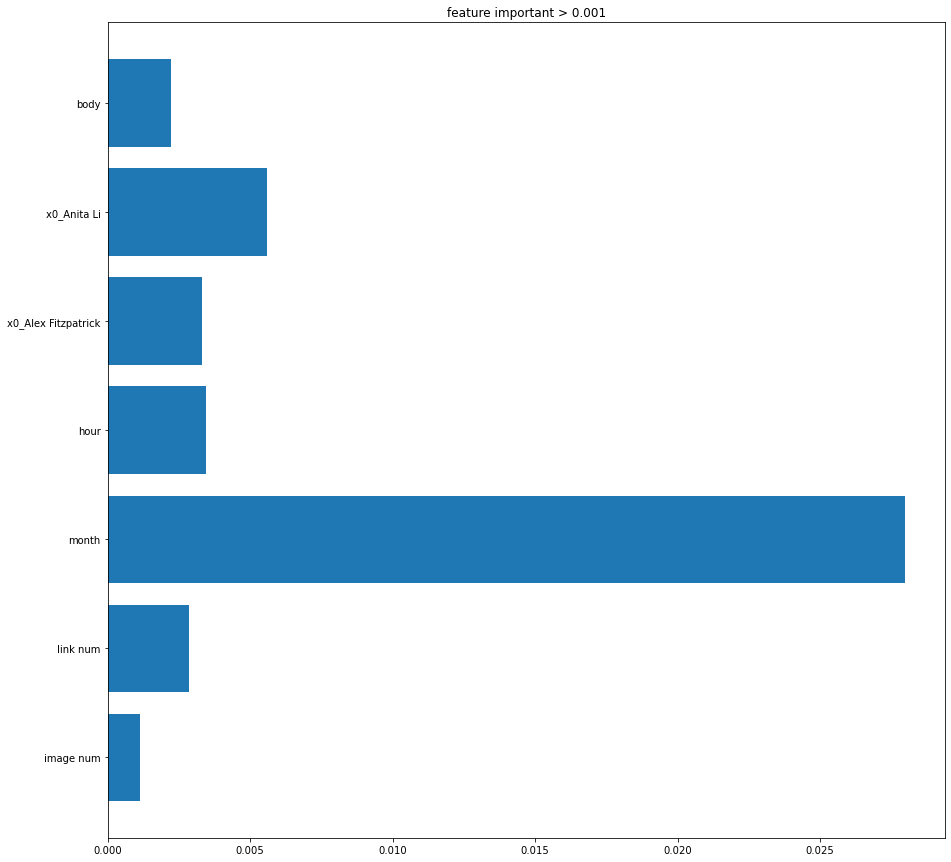

In [386]:
feat_imp = clf.steps[1][1].feature_importances_[: length]

print('feature important > 0.001')
feat_idx = np.where(feat_imp > 0.001)
feat_name = np.array(get_column_names_from_ColumnTransformer(preprocessorAll))

plt.figure(figsize=(15,15))
plt.title('feature important > 0.001')
plt.barh(feat_name[feat_idx], clf.steps[1][1].feature_importances_[feat_idx])
plt.show()


# XGBoost with tuning

In [487]:
from sklearn.model_selection import cross_val_score

params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 2, 
    'gamma': 0.30,
    'max_depth': 4,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.01,
    'seed': 1000,
    'nthread': 4,
}

pipe_xgb_tuning = Pipeline([
    ("preprocessorAll", preprocessorAll),
    ("xgbclf", XGBClassifier(num_rounds = 400).set_params(**params))
])

pipe_xgb_tuning.fit(df_train, y)

# scores = cross_val_score(pipe_xgb_tuning, df_train, y, cv=3)
# print(scores)

# gamma = [0.01, 0.1]
# max_depth = [4, 6]

# # by adding two underlines (__) between step name and parameter name
# param_grid = [{ 'xgbclf__gamma': gamma,
#                 'xgbclf__max_depth': max_depth}]

# gs_xgb = GridSearchCV(
#     estimator = pipe_xgb_tuning, 
#     param_grid = param_grid, 
#     scoring = "roc_auc",
#     cv = 3
# )

# gs_xgb = gs_xgb.fit(df_train, y)
# print('[XGBoost: grid search]')
# print('Validation accuracy: %.3f' % gs_xgb.best_score_)
# print(gs_xgb.best_params_)

# clf_best = gs_xgb.best_estimator_
# clf_best.fit(df_train, y)

C:\Users\ginag\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ginag\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:00:22] WARNING: ..\src\learner.cc:541: 
Parameters: { num_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:00:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessorAll',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scl', StandardScaler(),
                                                  ['image num', 'video num',
                                                   'link num', 'month',
                                                   'hour']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['author', 'year']),
                                                 ('hash',
                                                  HashingVectorizer(n_features=1024,
                                                                    preprocessor=<function preprocessor at 0x0000025B3F0275E0>,
                                                    

feature important > 0.001
['image num' 'video num' 'link num' 'month' 'hour' 'x0_'
 'x0_ Amy-Mae Turner' 'x0_#MAKEFURHISTORY' 'x0_AJ Marechal' 'x0_Aaron Lee'
 'x0_Aaron Miguel Cantú' 'x0_Adam Foroughi' 'x0_Adam Ostrow'
 'x0_Adam Popescu' 'x0_Adario Strange' 'x0_Adelle Waldman'
 'x0_Admiral James Stavridis' 'x0_Adobe Marketing Cloud' 'x0_Adora Svitak'
 'x0_Afifa Siddiqui' 'x0_Alan Carniol' 'x0_Alan Danzis'
 'x0_Alex Fitzpatrick' 'x0_Alex Hazlett' 'x0_Alex Howard'
 'x0_Alex Magdaleno' 'x0_Alex Thomson' 'x0_Alex Torrenegra'
 'x0_Alexis Grant' 'x0_Allison Kent-Smith' 'x0_Allison Reiber'
 'x0_Amanda Dixon' 'x0_Amanda Wills' 'x0_Amit Chauhan' 'x0_Amit De'
 'x0_Amy Burke' 'x0_Amy Webb' 'x0_Ana Rosenstein' 'x0_Andre Lavoie'
 'x0_Andrea Romano' 'x0_Andrea Smith' 'x0_Andrew Freedman'
 'x0_Andrew Van Noy' 'x0_Andy Fixmer' 'x0_Anita Li'
 'x0_Ann-Marie Alcantara' 'x0_Anna Parsons' 'x0_Anna Washenko'
 'x0_Anne Park' 'x0_Annie Colbert' 'x0_Ari Ratner' 'x0_Armand Valdes'
 'x0_Ashley Codianni' 'x0_Ashl

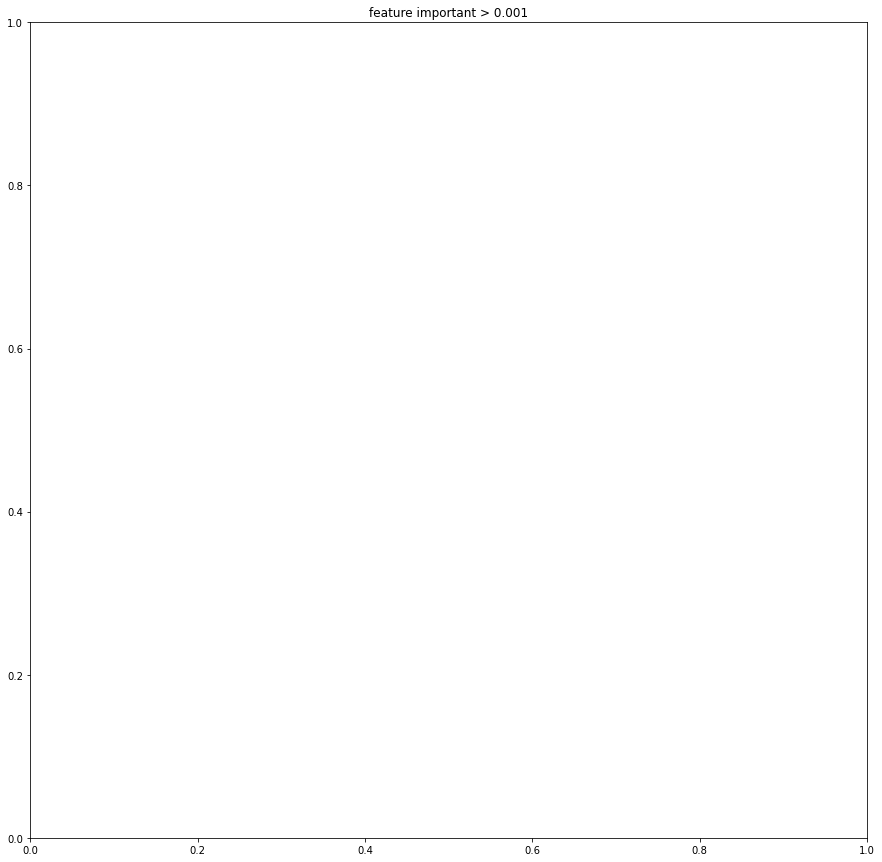

In [474]:
feat_imp = pipe_xgb_tuning.steps[1][1].feature_importances_[:437]

print('feature important > 0.001')
feat_idx = np.where(feat_imp > 0.001)
feat_name = np.array(get_column_names_from_ColumnTransformer(preprocessorAll))

plt.figure(figsize=(15,15))
plt.title('feature important > 0.001')

# print(feat_idx)
print(feat_name)
# plt.barh(feat_name[feat_idx], feat_imp[feat_idx])
# plt.show()


In [476]:
pipe_xgb_tuning.steps[1][1].feature_importances_


array([0.0011201 , 0.00210191, 0.00142957, ..., 0.00801752, 0.01091736,
       0.00572219], dtype=float32)

In [496]:
test['Popularity'] = pipe_xgb_tuning.predict_proba(df_test)[:, 1]
test[['Id', 'Popularity']].to_csv('data/test_xgb_new_fea.csv', index=False)